# Практическое задание №8 по теме "Generative Adversarial Networks".

Обучить генератор создавать точки, которые будут лежать на графике функции $y=\frac{sin(x)}{x} - \frac{x}{10}$<br>
При выполнении данного задания структура GAN остается той же, но Вам нужно:
* Сгенерировать настоящие данные
* Изменить архитектуру дискриминатора и генератора
* Построить графики

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
torch.manual_seed(15)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Обозначим точки $x$ и $y$

In [4]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.randn(train_data_length)
train_data[:, 1] = (torch.sin(train_data[:, 0])/ (train_data[:, 0])) - ((train_data[:, 0])/10)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

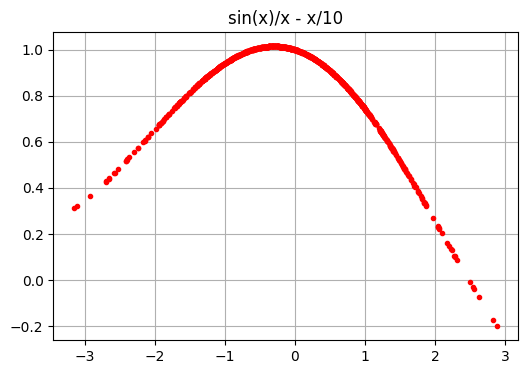

In [5]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(train_data[:, 0], train_data[:, 1], ".", color='r')
plt.title('sin(x)/x - x/10')
plt.grid()
plt.show()

### Модель

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

### Обучение сети

In [9]:
lr = 0.001
num_epochs = 2001
loss_function = torch.nn.BCELoss()

In [10]:
generator = Generator()
discriminator = Discriminator()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
      
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        if epoch % 100 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}") 

Epoch: 0 Loss D.: 0.17487169802188873
Epoch: 0 Loss G.: 2.569124698638916
Epoch: 100 Loss D.: 0.6964484453201294
Epoch: 100 Loss G.: 0.6927316188812256
Epoch: 200 Loss D.: 0.646428108215332
Epoch: 200 Loss G.: 0.84662926197052
Epoch: 300 Loss D.: 0.5601434707641602
Epoch: 300 Loss G.: 1.2493364810943604
Epoch: 400 Loss D.: 0.5030583143234253
Epoch: 400 Loss G.: 1.8648518323898315
Epoch: 500 Loss D.: 0.587350606918335
Epoch: 500 Loss G.: 0.8500359654426575
Epoch: 600 Loss D.: 0.6668850183486938
Epoch: 600 Loss G.: 0.7962985634803772
Epoch: 700 Loss D.: 0.5505855083465576
Epoch: 700 Loss G.: 1.0730094909667969
Epoch: 800 Loss D.: 0.6305451393127441
Epoch: 800 Loss G.: 0.7819515466690063
Epoch: 900 Loss D.: 0.5921738147735596
Epoch: 900 Loss G.: 0.8708542585372925
Epoch: 1000 Loss D.: 0.6804733872413635
Epoch: 1000 Loss G.: 0.7288724184036255
Epoch: 1100 Loss D.: 0.7087153792381287
Epoch: 1100 Loss G.: 0.730686604976654
Epoch: 1200 Loss D.: 0.605012834072113
Epoch: 1200 Loss G.: 0.9459065

### Генерация и графики

In [12]:
latent_space_samples = torch.randn(1000, 2)
generated_samples = generator(latent_space_samples)

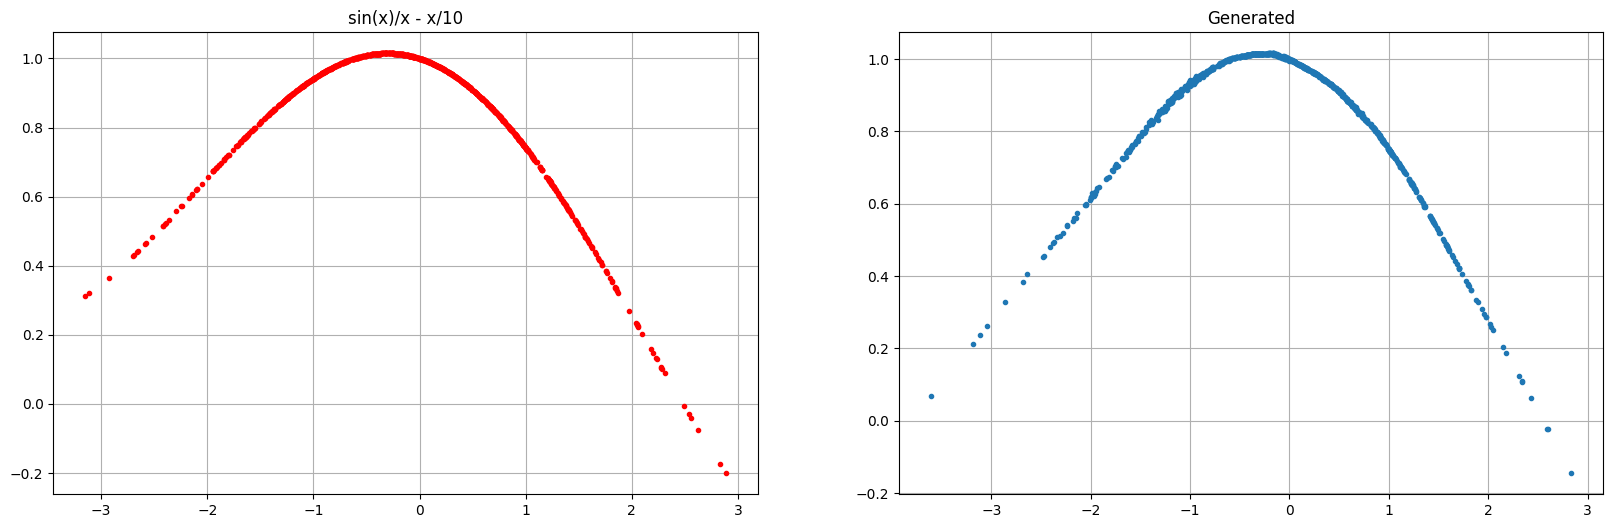

In [14]:
generated_samples = generated_samples.detach()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.set_title('sin(x)/x - x/10')
ax1.grid(True)
ax1.plot(train_data[:, 0], train_data[:, 1], ".", color='r')

ax2.set_title('Generated')
ax2.grid(True)
ax2.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.show()

---